In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [14]:
# Define your text dataset
text_path=r"D:\SLIIT\Birds Implementation\birds\text_c10"

# Load the text data from all subdirectories
text_dataset = []
for root, dirs, files in os.walk(text_path):
    for file_name in files:
        if file_name.endswith('.txt'):
            file_path = os.path.join(root, file_name)
            with open(file_path, 'r') as file:
                description = file.read()
                text_dataset.append(description)

# Preprocess the text data
tokenizer = Tokenizer()
# Continue with the remaining code using the text_dataset
tokenizer.fit_on_texts(text_dataset)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(text_dataset)
max_sequence_length = max([len(sequence) for sequence in sequences])

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [15]:
# Load the image data
image_dataset_folder = r"D:\SLIIT\Birds Implementation\CUB_200_2011\images"


# Load the image data from all subdirectories
image_dataset = []
for root, dirs, files in os.walk(image_dataset_folder):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        image = Image.open(file_path).convert("L")  # Convert to grayscale
        image = image.resize((28, 28))  # Resize the image to match the desired input size
        image = np.array(image)  # Convert the image to a NumPy array
        image_dataset.append(image)

images = np.array(image_dataset)
images = images.reshape(-1, 28, 28, 1)

y = np.array([1] * len(sequences))  # Update with the corresponding labels for the images

In [16]:
# Convert the data to NumPy arrays
max_sequence_length = max([len(sequence) for sequence in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [17]:
# Define the generator model
generator = Sequential()
generator.add(Dense(256, input_dim=max_sequence_length))
generator.add(Reshape((1, 1, 256)))
generator.add(Conv2DTranspose(128, (7, 7), strides=(1, 1), padding='valid'))
generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
generator.add(Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='tanh'))

# Define the discriminator model
discriminator = Sequential()
discriminator.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(max_sequence_length,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00002, beta_1=0.5))

In [18]:
epochs = 5
batch_size = 32
num_samples = padded_sequences.shape[0]
num_batches = num_samples // batch_size

In [19]:
# Define the training loop
def train_gan(generator, discriminator, gan, sequences, images, epochs, batch_size):
    # Calculate the number of batches per epoch
    num_batches = len(sequences) // batch_size
    
    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            # Get a batch of real images
            real_images = images[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            
            # Get a batch of real sequences
            real_sequences = sequences[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            
            # Generate a batch of fake sequences
            generated_sequences = generator.predict(real_sequences)
            
            # Create a batch of combined images (real images and generated images)
            combined_images = np.concatenate([real_images, generated_sequences])
            
            # Create labels for the combined images (1 for real images, 0 for generated images)
            labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            
            # Train the discriminator
            discriminator_loss = discriminator.train_on_batch(combined_images, labels)
            
            # Generate a batch of random noise vectors
            noise = np.random.normal(0, 1, (batch_size, max_sequence_length))
            
            # Create labels for the generated sequences (1, since we want the generator to trick the discriminator)
            misleading_labels = np.ones((batch_size, 1))
            
            # Train the generator (via the GAN model), while keeping the discriminator weights fixed
            generator_loss = gan.train_on_batch(real_sequences, misleading_labels)
            
            # Print the loss values
            print(f"Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{num_batches} | Discriminator Loss: {discriminator_loss:.4f} | Generator Loss: {generator_loss:.4f}")

# Train the GAN
train_gan(generator, discriminator, gan, padded_sequences, images, epochs, batch_size)

1/1 [==============================] - 2s 2s/step
Epoch: 1/5 | Batch: 1/368 | Discriminator Loss: 0.3324 | Generator Loss: 0.8287
1/1 [==============================] - 0s 242ms/step
Epoch: 1/5 | Batch: 2/368 | Discriminator Loss: 0.3246 | Generator Loss: 0.8395
1/1 [==============================] - 0s 306ms/step
Epoch: 1/5 | Batch: 3/368 | Discriminator Loss: 0.2926 | Generator Loss: 0.9150
1/1 [==============================] - 0s 226ms/step
Epoch: 1/5 | Batch: 4/368 | Discriminator Loss: 0.2919 | Generator Loss: 0.9181
1/1 [==============================] - 0s 264ms/step
Epoch: 1/5 | Batch: 5/368 | Discriminator Loss: 0.2646 | Generator Loss: 0.9931
1/1 [==============================] - 0s 282ms/step
Epoch: 1/5 | Batch: 6/368 | Discriminator Loss: 0.2704 | Generator Loss: 0.9734
1/1 [==============================] - 0s 290ms/step
Epoch: 1/5 | Batch: 7/368 | Discriminator Loss: 0.2471 | Generator Loss: 1.0499
1/1 [==============================] - 0s 242ms/step
Epoch: 1/5 | Batch:

1/1 [==============================] - 1s 936ms/step


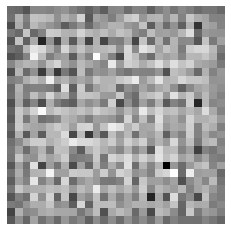

In [20]:
def generate_image_from_text(input_text):
    sequence = tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    generated_image = generator.predict(padded_sequence)
    return generated_image


input_text = "a girl"

generated_image = generate_image_from_text(input_text)

plt.imshow(generated_image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()